# 1. Overview

# 2. Data understanding

## 2.1 Data description

## 2.2 Importing Necessary Libraries

In [1]:
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...


True

## 2.3 Define global variables

In [2]:
pd.set_option('display.max_colwidth', 1000)

## 2.3 Functions

In [3]:
def identify_product(tweet_text):
    """
    Identify if the tweet is about a Google or Apple product, and replace any product-related keywords
    with 'tecproduct'.
    
    Parameters:
    tweet_text (str): The text of the tweet.
    
    Returns:
    str: 'Google' if the tweet mentions a Google product, 'Apple' if the tweet mentions an Apple product,
         'Both' if the tweet mentions both, 'Unknown' if it mentions neither.
    """
    google_keywords = ['google', 'pixel', 'pixels', 'nexus', 'nexuses', 'android', 'androids', 
                       'chromebook', 'chromebooks', 'nest', 'nests', 'stadia', 'stadias']
    apple_keywords = ['apple', 'apples', 'iphone', 'iphones', 'ipad', 'ipads', 'macbook', 
                      'macbooks', 'imac', 'imacs', 'watch', 'watches', 'airpods', 
                      'appstore', 'ios', 'itunes']
    
    # Ensure tweet_text is a string
    if not isinstance(tweet_text, str):
        return 'Unknown'
    
    # Replace "app store" with "appstore" before tokenization
    tweet_text = tweet_text.replace("app store", "appstore")
    
    # Replace any occurrences of google_keywords and apple_keywords with 'tecproduct'
    for keyword in google_keywords + apple_keywords:
        tweet_text = re.sub(rf'\b{keyword}\b', 'tecproduct', tweet_text, flags=re.IGNORECASE)
        
    # Replace @ followed by any text or numbers with 'user'
    tweet_text = re.sub(r'@\w+', 'user', tweet_text)
    
    # Remove # in front of tecproduct if there is
    tweet_text = re.sub(r'#tecproduct', 'tecproduct', tweet_text)
    
    # Replace # followed by any text or numbers with 'trend'
    tweet_text = re.sub(r'#\w+', 'trend', tweet_text)
    
    # Remove URLs
    tweet_text = re.sub(r'http\S+|www\S+|https\S+', 'urls', tweet_text, flags=re.MULTILINE)
    
    # Rename 1g, 2g, 3g, 4g, 5g, 6g, to 'monetwork'
    tweet_text = re.sub(r'\dg', 'monetwork', tweet_text)
    
    return tweet_text


In [4]:
def preprocess_product_mention(df):
    df['product_mention'] = df['product_mention'].astype(str)
    return df

# 3. Code

## 3.1 Import the database

In [5]:
# Load and prepare data
df = pd.read_csv('df.csv')

## 3.2 Highlighting tech products 

Let's make the tweets lowercase

In [6]:
df['tweet_text'] = df['tweet_text'].str.lower()

df.head()

,tweet_text,emotion_type,product_mention
0,".@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead! i need to upgrade. plugin stations at #sxsw.",Negative emotion,Apple
1,"@jessedee know about @fludapp ? awesome ipad/iphone app that you'll likely appreciate for its design. also, they're giving free ts at #sxsw",Positive emotion,Apple
2,@swonderlin can not wait for #ipad 2 also. they should sale them down at #sxsw.,Positive emotion,Apple
3,@sxsw i hope this year's festival isn't as crashy as this year's iphone app. #sxsw,Negative emotion,Apple
4,"@sxtxstate great stuff on fri #sxsw: marissa mayer (google), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",Positive emotion,Google


We have decided to rename all the technical products in the tweet_text column to a general name called tecproduct. As well as substituting all tags in a tweet with a generic name called User, and the # for another generic name called trend. Lastly, we have also replace all urls with a generic name called url. In this way, we will be able to have a more generalized tweet. 

In [7]:
df['tweet_text'] = df['tweet_text'].map(identify_product)

In [8]:
df.head()

,tweet_text,emotion_type,product_mention
0,".user i have a monetwork tecproduct. after 3 hrs tweeting at trend, it was dead! i need to upgrade. plugin stations at trend.",Negative emotion,Apple
1,"user know about user ? awesome tecproduct/tecproduct app that you'll likely appreciate for its design. also, they're giving free ts at trend",Positive emotion,Apple
2,user can not wait for tecproduct 2 also. they should sale them down at trend.,Positive emotion,Apple
3,user i hope this year's festival isn't as crashy as this year's tecproduct app. trend,Negative emotion,Apple
4,"user great stuff on fri trend: marissa mayer (tecproduct), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",Positive emotion,Google


## 3.3 Text cleaning

### 3.3.1 Stop Words

Let's now proceed to eliminate the stopwords

In [9]:
stopwords_to_remove = stopwords.words('english')

df['tweet_text'] = df['tweet_text'].map(lambda x: ' '.join([word for word in x.split() if word not in stopwords_to_remove]))

df.head()

,tweet_text,emotion_type,product_mention
0,".user monetwork tecproduct. 3 hrs tweeting trend, dead! need upgrade. plugin stations trend.",Negative emotion,Apple
1,"user know user ? awesome tecproduct/tecproduct app likely appreciate design. also, they're giving free ts trend",Positive emotion,Apple
2,user wait tecproduct 2 also. sale trend.,Positive emotion,Apple
3,user hope year's festival crashy year's tecproduct app. trend,Negative emotion,Apple
4,"user great stuff fri trend: marissa mayer (tecproduct), tim o'reilly (tech books/conferences) &amp; matt mullenweg (wordpress)",Positive emotion,Google


We will now proceed to remove strange characters and punctuation

In [10]:
# Remove strange characters and punctuation
strange_chars = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~“!#Ûª'
df['tweet_text'] = df['tweet_text'].map(lambda x: x.translate(str.maketrans(strange_chars, ' ' * len(strange_chars))))

df.head()

,tweet_text,emotion_type,product_mention
0,user monetwork tecproduct 3 hrs tweeting trend dead need upgrade plugin stations trend,Negative emotion,Apple
1,user know user awesome tecproduct tecproduct app likely appreciate design also they re giving free ts trend,Positive emotion,Apple
2,user wait tecproduct 2 also sale trend,Positive emotion,Apple
3,user hope year s festival crashy year s tecproduct app trend,Negative emotion,Apple
4,user great stuff fri trend marissa mayer tecproduct tim o reilly tech books conferences amp matt mullenweg wordpress,Positive emotion,Google


Now we shall proceed to eliminate numbers

In [11]:
# Remove numbers
df['tweet_text'] = df['tweet_text'].map(lambda x: re.sub(r'\d+', '', x))

df.head()

,tweet_text,emotion_type,product_mention
0,user monetwork tecproduct hrs tweeting trend dead need upgrade plugin stations trend,Negative emotion,Apple
1,user know user awesome tecproduct tecproduct app likely appreciate design also they re giving free ts trend,Positive emotion,Apple
2,user wait tecproduct also sale trend,Positive emotion,Apple
3,user hope year s festival crashy year s tecproduct app trend,Negative emotion,Apple
4,user great stuff fri trend marissa mayer tecproduct tim o reilly tech books conferences amp matt mullenweg wordpress,Positive emotion,Google


We are going to eliminate letters that are on their own in each individual tweet

In [12]:
df['tweet_text'] = df['tweet_text'].map(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))

df.head()

,tweet_text,emotion_type,product_mention
0,user monetwork tecproduct hrs tweeting trend dead need upgrade plugin stations trend,Negative emotion,Apple
1,user know user awesome tecproduct tecproduct app likely appreciate design also they re giving free ts trend,Positive emotion,Apple
2,user wait tecproduct also sale trend,Positive emotion,Apple
3,user hope year festival crashy year tecproduct app trend,Negative emotion,Apple
4,user great stuff fri trend marissa mayer tecproduct tim reilly tech books conferences amp matt mullenweg wordpress,Positive emotion,Google


## 3.4 Lematization

In [13]:
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize each word in tweet_text
df['tweet_text'] = df['tweet_text'].map(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

df.head()

,tweet_text,emotion_type,product_mention
0,user monetwork tecproduct hr tweeting trend dead need upgrade plugin station trend,Negative emotion,Apple
1,user know user awesome tecproduct tecproduct app likely appreciate design also they re giving free t trend,Positive emotion,Apple
2,user wait tecproduct also sale trend,Positive emotion,Apple
3,user hope year festival crashy year tecproduct app trend,Negative emotion,Apple
4,user great stuff fri trend marissa mayer tecproduct tim reilly tech book conference amp matt mullenweg wordpress,Positive emotion,Google


## 3.5 Tokenize

In [14]:
# Tokenize the tweet_text
df['tweet_text'] = df['tweet_text'].map(lambda x: word_tokenize(x))

df.head()

,tweet_text,emotion_type,product_mention,tweet_text_tokenized
0,user monetwork tecproduct hr tweeting trend dead need upgrade plugin station trend,Negative emotion,Apple,"[user, monetwork, tecproduct, hr, tweeting, trend, dead, need, upgrade, plugin, station, trend]"
1,user know user awesome tecproduct tecproduct app likely appreciate design also they re giving free t trend,Positive emotion,Apple,"[user, know, user, awesome, tecproduct, tecproduct, app, likely, appreciate, design, also, they, re, giving, free, t, trend]"
2,user wait tecproduct also sale trend,Positive emotion,Apple,"[user, wait, tecproduct, also, sale, trend]"
3,user hope year festival crashy year tecproduct app trend,Negative emotion,Apple,"[user, hope, year, festival, crashy, year, tecproduct, app, trend]"
4,user great stuff fri trend marissa mayer tecproduct tim reilly tech book conference amp matt mullenweg wordpress,Positive emotion,Google,"[user, great, stuff, fri, trend, marissa, mayer, tecproduct, tim, reilly, tech, book, conference, amp, matt, mullenweg, wordpress]"


## 3.6 Train test split

Let's first define our variables

In [15]:
y = df['emotion_type']
X = df.drop(['emotion_type', 'tweet_text_tokenized'], axis=1)

In [24]:
# X is the feature set and y is the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Let's compare the shapes of y_test and y_train to see if they're somewhat similar

In [25]:
y_test.value_counts(normalize=True)

no emotion          0.576008
Positive emotion    0.361340
Negative emotion    0.062652
Name: emotion_type, dtype: float64

In [26]:
y_train.value_counts(normalize=True)

no emotion          0.570943
Positive emotion    0.357791
Negative emotion    0.071267
Name: emotion_type, dtype: float64

Let's see a description of the distributions

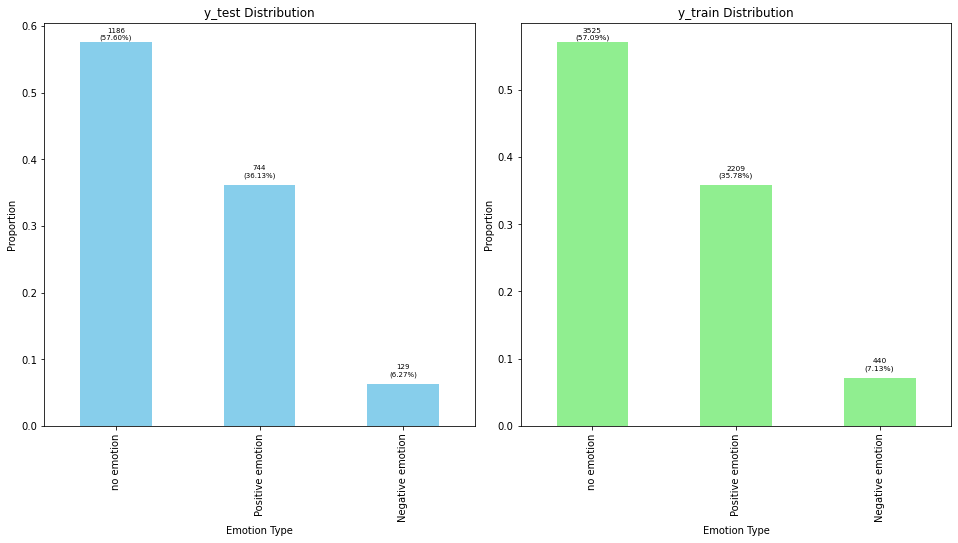

In [39]:
import matplotlib.pyplot as plt

# Assuming y_test and y_train are pandas Series

# Create a larger figure
plt.figure(figsize=(14, 7))

# y_test Distribution
plt.subplot(1, 2, 1)
y_test_counts = y_test.value_counts(normalize=True)
y_test_abs_counts = y_test.value_counts()

y_test_counts.plot(kind='bar', color='skyblue')
plt.title('y_test Distribution')
plt.xlabel('Emotion Type')
plt.ylabel('Proportion')

for i, (count, pct) in enumerate(zip(y_test_abs_counts, y_test_counts)):
    vertical_position = pct + 0.002 if pct > 0.5 else pct + 0.01  # Small offset for larger bars
    plt.text(i, vertical_position, f'{count}\n({pct:.2%})', ha='center', va='bottom', fontsize=7)

# y_train Distribution
plt.subplot(1, 2, 2)
y_train_counts = y_train.value_counts(normalize=True)
y_train_abs_counts = y_train.value_counts()

y_train_counts.plot(kind='bar', color='lightgreen')
plt.title('y_train Distribution')
plt.xlabel('Emotion Type')
plt.ylabel('Proportion')

for i, (count, pct) in enumerate(zip(y_train_abs_counts, y_train_counts)):
    vertical_position = pct + 0.002 if pct > 0.5 else pct + 0.01  # Small offset for larger bars
    plt.text(i, vertical_position, f'{count}\n({pct:.2%})', ha='center', va='bottom', fontsize=7.5)

# Adjust layout to make more space around the plots
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)
plt.show()


## 3.7 TFIDF

Let's proceed to vectorize 